In [1]:
# set up paths
from os import pardir, getcwd
from os.path import join, abspath
import sys
nb_dir = getcwd()
project_path = abspath(join(nb_dir, pardir))
sys.path.append(project_path)
# 3rd party imports
import matplotlib.pyplot as plt
from tqdm import tqdm
# ux imports
from ux.calcs.transitions import transition_probabilities
from ux.classes.ux.action_template import ActionTemplate
from ux.plots.transitions import plot_markov_chain
# local imports
from pmi_examples.helpers import create_card_view_task, abbreviate_slug
from managers.card_view_manager import CardViewManager
from paths.files import FN_INTERIM_CARD_VIEW

## Transition Diagrams (1st Order Markov Chain)

The transition probability and count diagrams in the previous notebook can be helpful for identifying likely areas of investigation for usability issues. However, where the expected navigation behavior is not strictly linear, it can be hard to interpret the sources and destinations. Sparse transition matrices like these are often better represented as Markov Diagrams

N.B.Python3 has a great library called `networkx` that can be used along with `graphviz` to produce compelling graph plots, as well as enabling export to open source formats. This may be incorporated later; however at the time of writing it did not seem worth adding all the dependencies for a single plot.

First, let's get the boilerplate code out of the way.

In [2]:
# set up db manager
db = CardViewManager(data=FN_INTERIM_CARD_VIEW)
# create task
task = create_card_view_task(
    db=db, search_text='critical-pm-relationships',
    task_name='Critical PM Relationships'
)
# get sequences from each session
sessions = db.sessions()
sequences = [
    db.get_session_sequence(session_id=session.session_id)
    for session in tqdm(sessions, 'Reading session sequences')
]

Reading session sequences: 100%|██████████| 1191/1191 [00:10<00:00, 117.16it/s]


We will be producing 2 diagrams, one with a more rectangular layout, and the other with a more row-based layout. For this we will sometime be defining 2 sets of variables along the way.

First the limits for the axes:

In [3]:
RECT_X_LIM = (-2, 8)
RECT_Y_LIM = (-2, 8)
ROW_X_LIM = (-1, 11)
ROW_Y_LIM = (-1, 7)

Now the layouts. The rectangular layout is pretty simple, since it's just calculating the row and column for each Location based on its order in the Task. The row layout is a bit more complicated because its parsing the name of each location which, as we saw earlier, is in the format: **/topic/{topic-name}/{lesson-number}/{card-number}**

In [4]:
def rectangular_layout(action_template: ActionTemplate):

    index = task.action_templates.index(action_template)
    row = int(index / 7)
    col = index - row * 7
    return col, row

In [5]:
def row_layout(action_template: ActionTemplate):

    def get_group(template: ActionTemplate):
        name = abbreviate_slug(template.source_id)
        group = name.split('|')[1]
        return int(group)

    def get_number(template: ActionTemplate):
        name = abbreviate_slug(template.source_id)
        number = name.split('|')[2]
        return int(number)

    def get_group_index(template: ActionTemplate):
        template_group = get_group(template)
        template_number = get_number(template)
        templates = [t for t in task.action_templates if get_group(t) == template_group]
        group_numbers = [get_number(t) for t in templates]
        return group_numbers.index(template_number)

    return get_group_index(action_template), get_group(action_template)

Next, a method to return the arrow color based on the Location's group

In [6]:
def get_arrow_color(action_template: ActionTemplate):

    name = abbreviate_slug(action_template.source_id)
    group = name.split('|')[1]
    return {
        '00': '#7fc97f',
        '01': '#beaed4',
        '02': '#fdc086',
        '03': '#ffff99',
        '04': '#386cb0',
        '05': '#f0027f',
    }[group]

And a similar method for the color of the location itself, with slightly lighter colors:

In [7]:
def get_state_color(action_template: ActionTemplate):

    name = abbreviate_slug(action_template.source_id)
    group = name.split('|')[1]
    return {
        '00': '#ccebc5',
        '01': '#decbe4',
        '02': '#fed9a6',
        '03': '#ffffcc',
        '04': '#b3cde3',
        '05': '#fbb4ae'
    }[group]

Now calculate the transition probabilities, as we did in the previous notebook

In [8]:
probs = transition_probabilities(
    task=task, action_sequences=sequences
)

And finally, we can generate our plots:

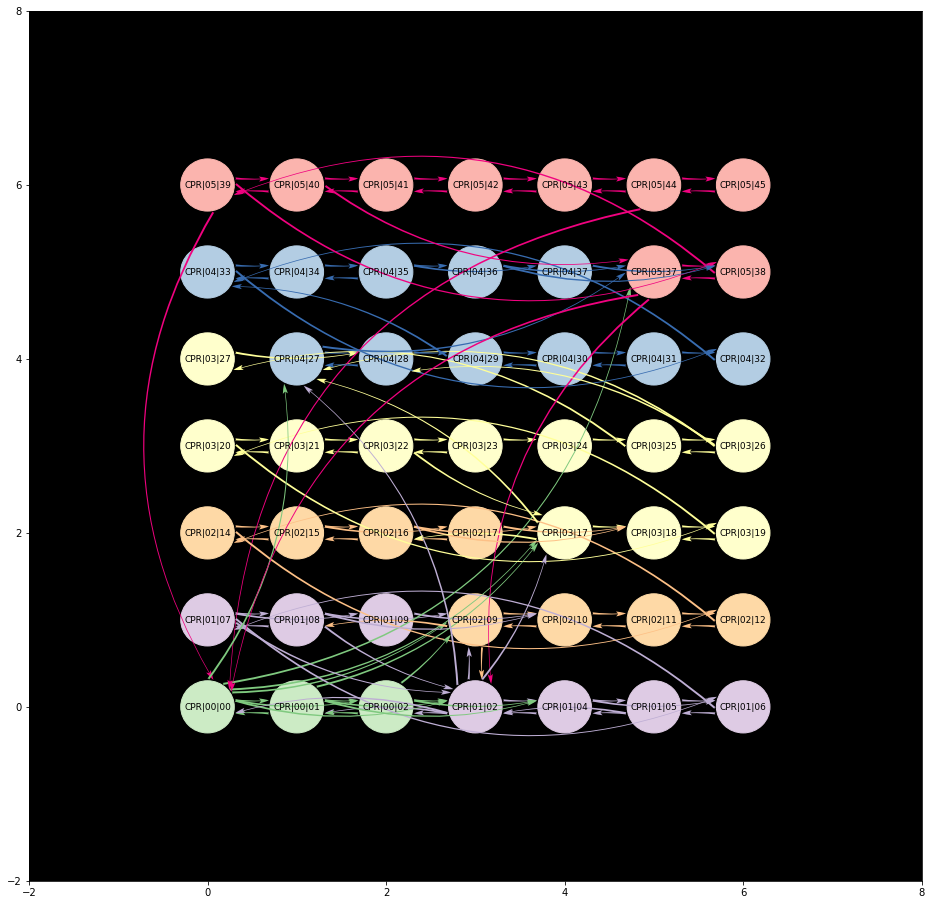

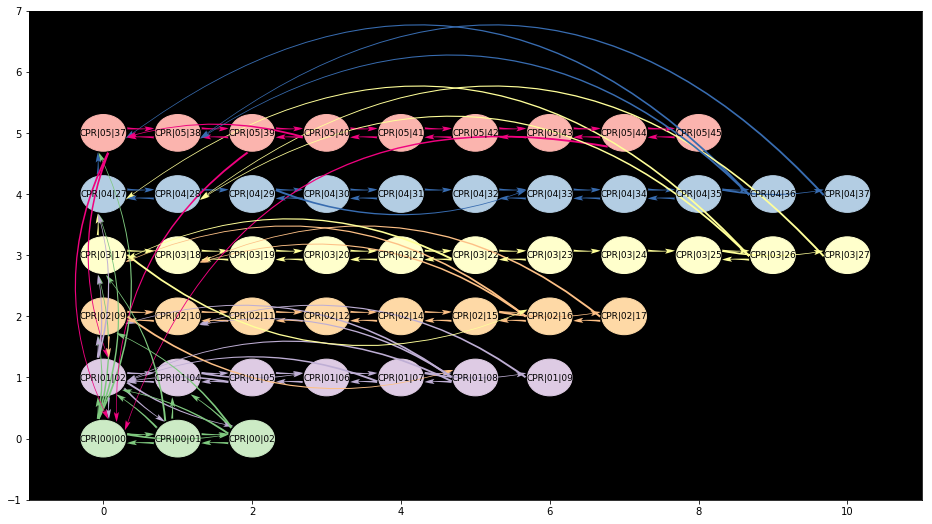

In [9]:
for fig_size, x_lim, y_lim, layout in zip(
    ((16, 16), (16, 9)),
    (RECT_X_LIM, ROW_X_LIM),
    (RECT_Y_LIM, ROW_Y_LIM),
    (rectangular_layout, row_layout)
):
    fig, ax = plt.subplots(figsize=fig_size)
    plot_markov_chain(
        transitions=probs,
        get_location=lambda action: layout(action),
        get_name=lambda action: abbreviate_slug(action.source_id),
        ax=ax, state_color=get_state_color, transition_color=get_arrow_color,
        arc_scale=0.05,
        text_kws=dict(fontsize=9, ha='center', va='center', color='black'),
        circle_kws=dict(radius=0.3)
    )
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.set_facecolor('black')

N.B. this method is in a **very** alpha stage, so does not yet show the transition probabilities or counts between states but in the meantime it can help to provide a more intuitive visualization of the routes Users are taking around an app.